<a href="https://colab.research.google.com/github/GabrielQuinteiro/recommendation-product-engine/blob/main/Recommendation_engine_v1_0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation Engine with PySpark

<font size=3>This recommendation engine uses implicit feedback data from an e-commerce website, which includes user interactions such as views, carts, and purchases. [Dataset Link](https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store)

<font size=3>The engine provides personalized recommendations to users by using matrix factorization with the Alternating Least Squares algorithm along with other features such as purchase per view. Additionally, it identifies substitute and supplementary products by comparing their vectors using the Locality Sensitive Hashing algorithm.

<font size=3>By improving the user experience and increasing customer satisfaction and retention, the project aimes to increase sales and profit on the platform. The highly personalized nature of the recommendation scores make this engine a valuable tool for any e-commerce company looking to improve their product recommendations.

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import math
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import pyarrow

import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Initialize Spark session

sc = SparkSession.builder.appName("Product_Recommendation") \
.config ("spark.sql.shuffle.partitions", "16") \
.config("spark.driver.maxResultSize","4g") \
.config ("spark.sql.execution.arrow.enabled", "true") \
.config("spark.driver.memory", "4g") \
.config("spark.executor.cores", "4") \
.getOrCreate()

sc.sparkContext.setLogLevel("ERROR")

In [ ]:
df = sc.read.option('header', True).csv('/content/drive/MyDrive/ColabNotebooks/2019-Nov.csv')
df = df.sample(0.001, seed=321)

In [ ]:
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



In [ ]:
df.show(5, truncate=False)

+-----------------------+----------+----------+-------------------+-------------------------+------+------+---------+------------------------------------+
|event_time             |event_type|product_id|category_id        |category_code            |brand |price |user_id  |user_session                        |
+-----------------------+----------+----------+-------------------+-------------------------+------+------+---------+------------------------------------+
|2019-11-01 00:00:00 UTC|view      |1003461   |2053013555631882655|electronics.smartphone   |xiaomi|489.07|520088904|4d3b30da-a5e4-49df-b1a8-ba5943f1dd33|
|2019-11-01 00:00:00 UTC|view      |5000088   |2053013566100866035|appliances.sewing_machine|janome|293.65|530496790|8e5f4f83-366c-4f70-860e-ca7417414283|
|2019-11-01 00:00:01 UTC|view      |17302664  |2053013553853497655|NULL                     |creed |28.31 |561587266|755422e7-9040-477b-9bd2-6a6e8fd97387|
|2019-11-01 00:00:01 UTC|view      |3601530   |2053013563810775923|app

## Exploratory Data Analysis

In [ ]:
# Null values

df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|          0|     21898171|9218235|    0|      0|          10|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+



In [ ]:
# Number of events

df.groupBy('event_type').count().show()

+----------+--------+
|event_type|   count|
+----------+--------+
|      cart| 3028930|
|  purchase|  916939|
|      view|63556110|
+----------+--------+



<Axes: ylabel='count'>

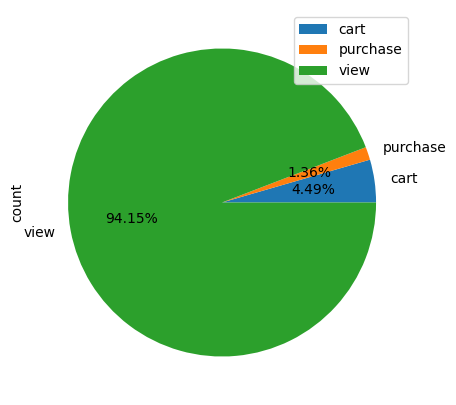

In [ ]:
# Plot events distribution

events = df.groupBy('event_type').count().toPandas()
events.plot(kind='pie', y='count', labels=events['event_type'], autopct='%1.2f%%', figsize=(5, 5))

In [ ]:
df.select(f.countDistinct("product_id")).show()

# 190k products

+--------------------------+
|count(DISTINCT product_id)|
+--------------------------+
|                    190662|
+--------------------------+



<font size=3>Check whether all products belong to a single category by grouping products by their ID, collecting their category IDs into a set, and printing the number of products that belong to a single category.

In [ ]:
df.groupby('product_id').agg(f.collect_set('category_id'))\
                        .filter(size(col('collect_set(category_id)')) == 1).count()

# All products belong to a single category

190662

In [ ]:
df.select(f.countDistinct("category_id")).show()

# 684 categories

+---------------------------+
|count(DISTINCT category_id)|
+---------------------------+
|                        684|
+---------------------------+



In [ ]:
df.drop_duplicates(subset=['category_id']).select(f.count("category_code")).show()

# Some categories (275/684) have a category code represantation

+--------------------+
|count(category_code)|
+--------------------+
|                 275|
+--------------------+



In [ ]:
df.select(f.countDistinct("category_code")).show()

# 129 distinct category code represantations, some categories (146/275) have the same category codes

+-----------------------------+
|count(DISTINCT category_code)|
+-----------------------------+
|                          129|
+-----------------------------+



In [ ]:
df.select(f.countDistinct("user_id")).show()

# 3.7m users in one month

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                3696117|
+-----------------------+



In [ ]:
df.select(f.countDistinct("user_session")).show()

# 13.8m sessions

+----------------------------+
|count(DISTINCT user_session)|
+----------------------------+
|                    13776050|
+----------------------------+



<Axes: xlabel='date'>

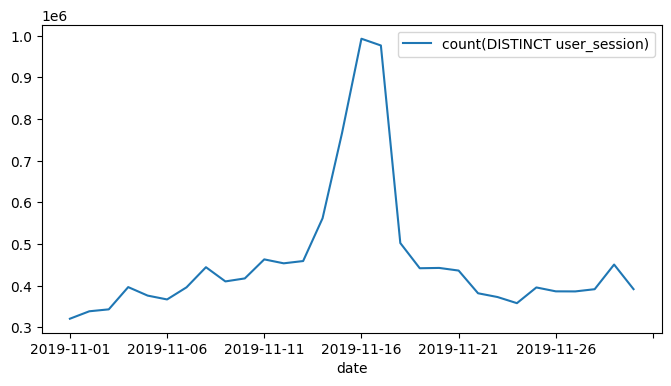

In [ ]:
# Plot the daily number of sessions

df = df.withColumn('event_time', to_timestamp('event_time'))
df = df.withColumn('date', date_format("event_time", "yyyy-MM-dd"))

sessions = df.groupby('date').agg(countDistinct('user_session')).toPandas()
sessions.sort_values('date').plot(x='date', figsize=(8, 4))

<font size=3>The number of sessions increased noticeably between November 15th-18th, which could be attributed to an advertising campaign or promotional activity.

<font size=3>On the other hand, the dataset has a small number of sessions for December 1st, which should not have been present in the November dataset.

In [ ]:
# Print the number of interactions between users and products, sorted by carts

interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'view', 1)).alias('views'),
                                                         sum(when(df['event_type'] == 'cart', 1)).alias('carts'),
                                                         sum(when(df['event_type'] == 'purchase', 1)).alias('purchases'))

interactions.sort('carts', ascending=False).show()

+---------+----------+-----+-----+---------+
|  user_id|product_id|views|carts|purchases|
+---------+----------+-----+-----+---------+
|512875426|  15300303|    2|  709|     NULL|
|521558076|   1005008|   18|  554|        1|
|571769879|  12720043|    5|  354|        1|
|513824664|   3601489|   12|  273|     NULL|
|515642515|  13101546|   38|  237|     NULL|
|564808105|   1002633|   22|  210|     NULL|
|564068124|   1004833|  294|  207|      216|
|513754375|  50600004|    6|  203|     NULL|
|514553781|   1004856|    4|  192|        1|
|515911561|   1004858|    7|  191|     NULL|
|557590749|   8800045|    2|  186|     NULL|
|549030056|   1004856|  193|  181|      118|
|559057489|   3700912|    2|  174|     NULL|
|538042220|  12720092|    2|  168|        1|
|515793237|  22700078|   31|  164|     NULL|
|543128872|   4804056|  190|  154|      150|
|515032042|   1004873|   19|  152|        1|
|571683521|   1004870|   16|  151|        1|
|518514099|   1005116|  158|  147|      140|
|564068124

<font size=3>The data reveals a significant number of user-product pairs having a large number of carts, but very few views and purchases.

<font size=3>Further analysis shows that many of these cart events occurred during the same session, which could be due to users repeatedly adding and removing the product.

<font size=3>However, the data does not contain information on remove from cart events, thus we should restrict the number of carts to one per session for each user-product pair.

## Preprocess

In [ ]:
def preprocess(df):

    # Change data types
    df = df.withColumn('event_time', to_timestamp('event_time'))
    df = df.withColumn('user_id', col('user_id').cast('integer'))
    df = df.withColumn('product_id', col('product_id').cast('integer'))
    df = df.withColumn('category_id', col('category_id').cast('long'))

    # Limit the number of carts to 1 per session for each user-product pair
    cart_df = df.filter(col('event_type') == 'cart')
    df = df.filter(col('event_type') != 'cart')
    cart_df = cart_df.dropDuplicates(subset=['product_id', 'user_id', 'user_session'])
    df = df.union(cart_df)

    # Split category codes into sub categories
    #df = df.withColumn('category', split(df['category_code'], '\.').getItem(0)) \
    #   .withColumn('sub_category', split(df['category_code'], '\.').getItem(1)) \
    #   .withColumn('sub_sub_category', split(df['category_code'], '\.').getItem(2))

    return df

In [ ]:
df = preprocess(df)

## Feature Engineering

<font size=3>We can extract several features for users, products and categories using the behavioral data:


- Views/carts/purchases: The number of times a user has interacted with a product.


- Distinct products viewed/carted/purchased: The number of unique products a user has viewed, added to their cart, or purchased.


- Average (relative) price viewed/purchased: The average price of products a user has viewed or purchased.


- Interaction rates: These are derived features that provide insights into the behavior of users, such as the purchase per view, cart per view, and purchase per cart rate.

In [ ]:
def product_features(df):

    # Calculate several metrics for products with the aggregate function
    df = df.groupby('product_id').agg(first('category_id').alias('category_id'),
                                      first('category_code').alias('category_code'),
                                      count(when(df['event_type'] == 'view', True)).alias('views'),
                                      count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                      count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                      mean('price').alias('price'),
                                      min('event_time').alias('first_date'),
                                      max('event_time').alias('last_date'))

    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', df['purchases'] / df['views'])
    df = df.withColumn('cart_per_view', df['carts'] / df['views'])
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))

    return df

In [ ]:
def category_features(df):

    # Calculate the average product price for each category
    products = df.dropDuplicates(subset=['product_id'])
    products = products.groupby('category_id').agg(avg('price').alias('average_price'))

    # Calculate several metrics for categories with the aggregate function
    df = df.groupby('category_id').agg(first('category_code').alias('category_code'),
                                       countDistinct('product_id').alias('number_of_products'),
                                       count(when(df['event_type'] == 'view', True)).alias('views'),
                                       count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                       count(when(df['event_type'] == 'purchase', True)).alias('purchases'))

    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', df['purchases'] / df['views'])
    df = df.withColumn('cart_per_view', df['carts'] / df['views'])
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))

    df = df.join(products, on='category_id')

    return df

In [ ]:
def user_features(df):

    # Calculate several metrics for users with the aggregate function
    df = df.groupby('user_id').agg(count(when(df['event_type'] == 'view', True)).alias('views'),
                                   count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                   count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                   countDistinct(when(df['event_type'] == 'view', col('product_id'))).alias('distinct_products_viewed'),
                                   countDistinct(when(df['event_type'] == 'cart', col('product_id'))).alias('distinct_products_carted'),
                                   countDistinct(when(df['event_type'] == 'purchase', col('product_id'))).alias('distinct_products_purchased'),
                                   mean(when(df['event_type'] == 'view', col('price'))).alias('average_price_viewed'),
                                   mean(when(df['event_type'] == 'purchase', col('price'))).alias('average_price_purchased'),
                                   mean(when(df['event_type'] == 'view', col('relative_price'))).alias('avg_relative_price_viewed'),
                                   mean(when(df['event_type'] == 'purchase', col('relative_price'))).alias('avg_relative_price_purchased'),
                                   min('event_time').alias('first_date'),
                                   max('event_time').alias('last_date'))

    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', when(df['views'] == 0, df['purchases']).otherwise(df['purchases'] / df['views']))
    df = df.withColumn('cart_per_view', when(df['views'] == 0, df['carts']).otherwise(df['carts'] / df['views']))
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))

    return df

<font size=3>Some products and categories have very few interactions, this makes their interaction rates unreliable. For example, a product that has been viewed only 2 times and purchased 1 time would have a purchase per view rate of 0.5, which is very high. Therefore, it's important to apply smoothing to avoid overfitting on small sample sizes.

<font size=3>The smoothing works by taking a weighted average of the product's rate and the category's rate. The weight given to the product's rate depends on the number of interactions, with more weight given to the product's rate as the number of interactions increases. The same smoothing is applied to categories as well, using the overall average interaction rates.

In [ ]:
# Calculate smoothed rates for categories with small sample size using means of all products to combat overfitting

def category_smoothener(categories, mean, attr, rate, min_sample_size=1000):

    # Weighted average of category value and overall mean
    categories = categories.withColumn(rate, when(categories[attr] < min_sample_size, ((categories[rate] * categories[attr]) + (mean * (min_sample_size - categories[attr]))) / min_sample_size).otherwise(categories[rate]))

    return categories

In [ ]:
# Calculate smoothed rates for products with small sample size using category means to combat overfitting

def product_smoothener(products, categories, attr, rate, min_sample_size=1000):

    category_rate = rate + '_cat'
    categories = categories.withColumnRenamed(rate, category_rate)
    products = products.join(categories['category_id', category_rate], on='category_id')

    # Weighted average of product value and category value
    products = products.withColumn(rate, when(products[attr] < min_sample_size, ((products[rate] * products[attr]) + (products[category_rate] * (min_sample_size - products[attr]))) / min_sample_size).otherwise(products[rate]))

    products = products.drop(category_rate)
    return products

<font size=3>We must calculate the relative price of each product with respect to its category by scaling its price based on the median and Inter Quartile Range of the category's prices. The median is used as a measure of central tendency and the IQR as a measure of variability.

<font size=3>This scaling accounts for differences in price ranges across categories, enabling us to compare product prices across categories more accurately and without bias. Relative prices will be used to determine if users have a tendency to interact with cheaper or more expensive products.

In [ ]:
# Calculate the price of each product relative to its category using the formula: (price - median) / IQR

def calculate_relative_price(products):

    categories = products.groupby('category_id').agg(percentile_approx('price', 0.25, 1000).alias('Q1'),
                                                     percentile_approx('price', 0.5, 1000).alias('median'),
                                                     percentile_approx('price', 0.75, 1000).alias('Q3'))
    # Interquartile range
    categories = categories.withColumn('IQR', col('Q3') - col('Q1'))
    categories = categories.withColumn('IQR', when(col('IQR') < 1, 1).otherwise(col('IQR')))

    # Calculate relative price
    products = products.join(categories, on='category_id')
    products = products.withColumn('relative_price', (col('price') - col('median')) / col('IQR'))

    # In order to avoid extreme values, set the max possible value to 5
    products = products.withColumn('relative_price', when(col('relative_price') > 5, 5).otherwise(col('relative_price')))

    # Set the min possible value to -5
    products = products.withColumn('relative_price', when(col('relative_price') < -5, -5).otherwise(col('relative_price')))

    products = products.select('product_id', 'relative_price')
    return products

In [ ]:
# Extract product and category features

products = product_features(df)
categories = category_features(df)

In [ ]:
# Calculate relative prices and append it to the main dataframe and product features

relative_prices = calculate_relative_price(products)

df = df.join(relative_prices, on='product_id')
products = products.join(relative_prices, on='product_id')

In [ ]:
# Calculate the average interaction rates for all products to smooth category features with low interaction

avg_purchase_per_view = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'view']['count'].values[0]
avg_cart_per_view = events[events['event_type'] == 'cart']['count'].values[0] / events[events['event_type'] == 'view']['count'].values[0]
avg_purchase_per_cart = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'cart']['count'].values[0]

categories = category_smoothener(categories, avg_purchase_per_view, 'views', 'purchase_per_view', 2000)
categories = category_smoothener(categories, avg_cart_per_view, 'views', 'cart_per_view', 2000)
categories = category_smoothener(categories, avg_purchase_per_cart, 'carts', 'purchase_per_cart', 200)

In [ ]:
# Smooth product features with low interaction using corresponding category features

products = product_smoothener(products, categories, 'views', 'purchase_per_view', 1000)
products = product_smoothener(products, categories, 'views', 'cart_per_view', 1000)
products = product_smoothener(products, categories, 'carts', 'purchase_per_cart', 100)

In [ ]:
# Extract user features

users = user_features(df)

In [ ]:
# Top 50 products in terms of purchases

products.sort('purchases', ascending=False).toPandas().head(50)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py", line 280, in _collect_as_arrow
    results = list(batch_stream)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/serializers.py", line 69, in load_stream
    for batch in self.serializer.load_stream(stream):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/serializers.py", line 111, in load_stream
    reader = pa.ipc.open_stream(stream)
  File "/usr/local/lib/python3.10/dist-packages/pyarrow/ipc.py", line 190, in open_stream
    return RecordBatchStreamReader(source, options=options,
  File "/usr/local/lib/python3.10/dist-packages/pyarrow/ipc.py", line 52, in __init__
    self._open(source, options=options, memory_pool=memory_pool)
  File "pyarrow/ipc.pxi", line 929, in pyarrow.lib._RecordBatchStreamReader._open
  File "pyarrow/error.pxi", line 154, in pyarrow.lib.pyarrow_internal_ch

KeyboardInterrupt: 

## Collaborative Filtering

<font size=3>A filtragem colaborativa é uma técnica usada em sistemas de recomendação para fornecer recomendações personalizadas aos usuários com base em suas interações anteriores com itens, bem como nas interações de usuários semelhantes. A matriz de interação contém informações sobre quais usuários interagiram com quais itens e em que grau.
    
<font size=3>O algoritmo Alternating Least Squares é uma abordagem para filtragem colaborativa que pode ser usada para treinar um modelo nesta matriz de interação. O modelo aprende fatores latentes tanto para usuários quanto para itens, que podem então ser usados ​​para fazer recomendações personalizadas e encontrar produtos semelhantes.
    
<font size=3>Deveríamos aplicar uma função de ponderação às interações com base na atualidade. Isso ocorre porque as interações recentes costumam ser mais indicativas das preferências atuais do usuário do que as interações mais antigas. Podemos usar uma função de decaimento de meia-vida, onde o peso dado a uma interação diminui pela metade após um determinado intervalo de tempo (20 dias). Ao ponderar mais as interações mais recentes, o algoritmo pode fornecer recomendações mais relevantes aos usuários.

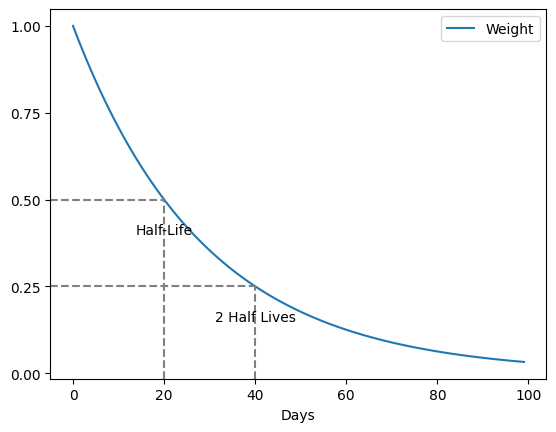

In [ ]:
# Plot the half-life decay function

half_life = 20
x = np.arange(0, 100)
y = np.power(0.5, x / half_life)
df = pd.DataFrame({'Days': x, 'Weight': y})

# Plot the function
ax = df.plot(x='Days', y='Weight')

# Add vertical lines at 20 and 40 days with explanatory text
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.axvline(x=20, linestyle='--', color='gray', ymax=0.49)
ax.axvline(x=40, linestyle='--', color='gray', ymax=0.25)
ax.axhline(y=0.5, linestyle='--', color='gray', xmax=0.23)
ax.axhline(y=0.25, linestyle='--', color='gray', xmax=0.41)
ax.text(20, 0.4, 'Half-Life', ha='center')
ax.text(40, 0.15, '2 Half Lives', ha='center')

plt.show()

In [ ]:
df.show(5, truncate=False)
# Get the timestamp of the most recent event in the df
# last_date = df.select(f.max('event_time')).collect()[0][0]
# df = df.withColumn('last_date', f.lit(last_date))

# # Calculate the recency of each event in terms of days
# df = df.withColumn('recency', (f.col('last_date').cast('double') - f.col('event_time').cast('double')) / 86400)
# df = df.drop('last_date')

# # Half-life decay function, the value of an event is halved after 20 days
# df = df.withColumn('recency_coef', f.expr('exp(ln(0.5)*recency/20)'))

AttributeError: 'DataFrame' object has no attribute 'show'

In [ ]:
# Find the number of views, carts and purchases for each user-product pair
interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'view', 1) * df['recency_coef']).alias('views'),
                                                         sum(when(df['event_type'] == 'cart', 1) * df['recency_coef']).alias('carts'),
                                                         sum(when(df['event_type'] == 'purchase', 1) * df['recency_coef']).alias('purchases'))
interactions = interactions.na.fill(0)

<font size=3>The interaction matrix is calculated by assigning weights to each type of user interaction. These weighted interactions are then summed to get the total interaction score, which has been subject to a half-life decay function to give more weight to recent interactions. Finally, the values are transformed by taking the logarithm with base 10 and capping the maximum value at 100 to ensure scalability and consistency, while reducing the effect of outliers. The resulting matrix provides a measure of strength of the relationship between users and products.

In [ ]:
def calculate_interaction_matrix(df, view_weight=0.1, cart_weight=0.3, purchase_weight=1.0):

    # Create a new column with the weighted interaction value
    df = df.withColumn('interaction', view_weight * col('views') + cart_weight * col('carts') + purchase_weight * col('purchases'))

    # Use log10 value for views, carts and purchases
    df = df.withColumn('interaction', log10(col('interaction') + 1))

    # Set the max possible value to 100 (log100 = 2)
    df = df.withColumn('interaction', when(col('interaction') > 2, 2).otherwise(col('interaction')))

    return df

In [ ]:
interaction_matrix = calculate_interaction_matrix(interactions)

In [ ]:
#  User-product pairs with the highest interaction scores

interaction_matrix.sort('interaction', ascending=False).show()

<font size=3>After creating an interaction matrix that quantifies user-product interactions using weights, we can feed this matrix into the ALS algorithm. This algorithm uses the matrix to learn the latent factors of both users and products, which can then be used to make personalized recommendations for users.
    
<font size=3>To optimize the performance of the ALS algorithm, we can use a cross-validation pipeline, which allows us to test and fine-tune different sets of parameters to find the best configuration for our recommendation system. Ultimately, the goal is to create a model that can make accurate and relevant product recommendations to users based on their previous interactions with the system.

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

def cross_validate_als(interaction_matrix):

    # Define the ALS model
    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction',
              nonnegative=True, coldStartStrategy='drop', implicitPrefs=True)

    # Define the parameter grid for hyperparameter tuning
    param_grid = ParamGridBuilder() \
        .addGrid(als.rank, [5, 10, 15, 20]) \
        .addGrid(als.regParam, [0.005, 0.01, 0.05, 0.1]) \
        .addGrid(als.alpha, [0, 1.0, 5.0]) \
        .build()

    # Define the evaluator for computing the evaluation metrics
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')

    # Define the cross-validator for performing 5-fold cross-validation
    cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, collectSubModels=False)

    # Define the pipeline for fitting the model and evaluating it
    pipeline = Pipeline(stages=[cv])

    # Fit the pipeline on the data and evaluate the model
    model = pipeline.fit(interaction_matrix)

    return model

In [ ]:
model = cross_validate_als(interaction_matrix)

# Model with the lowest RMSE value
bestModel = model.stages[0].bestModel

# Make predictions
predictions = bestModel.transform(interaction_matrix)

# Calculate RMSE and MAE metrics
evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
rmse = evaluator.setMetricName('rmse').evaluate(predictions)
mae = evaluator.setMetricName('mae').evaluate(predictions)
print(' rmse:' + str(rmse) + ' mae:' + str(mae))

# Print the parameters of the model with the lowest RMSE value
regParam = bestModel._java_obj.parent().getRegParam()
rank = bestModel._java_obj.parent().getRank()
alpha = bestModel._java_obj.parent().getAlpha()
print('rank:' + str(rank) + ' regParam:' + str(regParam) + ' alpha:' + str(alpha))

<font size=3>After identifying the best set of parameters, we can build an ALS model directly, instead of running the cross-validation function repeatedly. This approach saves time and resources, making it more efficient to generate product recommendations.

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

def simple_als(interaction_matrix):

    # Train-test split
    (train, test) = interaction_matrix.randomSplit([0.8, 0.2])

    # Initialize the model with the optimized parameters
    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction',
              alpha=1, regParam=0.005, rank=15, implicitPrefs=True,
              nonnegative=True, coldStartStrategy='drop')

    # Fit the ALS model on the ratings data
    model = als.fit(train)

    # Make predictions
    predictions = model.transform(test)

    # Calculate the RMSE and MAE metrics
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
    rmse = evaluator.evaluate(predictions)
    mae = evaluator.setMetricName('mae').evaluate(predictions)
    print('test rmse:' + str(rmse) + ' mae:' + str(mae))

    return model

In [ ]:
als_model = simple_als(interaction_matrix)

## Recommend Products for Users

In [ ]:
# 3 random users
user_subset = [565606905, 570112140, 564068124]

# Recommend top 500 products for the users
recommendations = sc.createDataFrame([(user, 0) for user in user_subset], ['user_id', 'product_id'])
recommendations = als_model.recommendForUserSubset(recommendations, 500)

In [ ]:
recommendations.show()

In [ ]:
# Select user 564068124

recs_for_user_1 = sc.createDataFrame(recommendations.collect()[1][1])

In [ ]:
# Products with the highest number of interactions for the user

interactions.filter(col('user_id') == 564068124).sort('purchases', ascending=False).show()

<font size=3>When generating recommendations, we can enhance the collaborative filtering (CF) scores by incorporating additional features that result in more engaging and personalized recommendations. With this function, we combine the CF scores with two other features: the conversion rate of the product and the spending habits of the user.

<font size=3>The calculation involves taking a weighted average of the three features. By default, the CF score carries the most weight, but we can adjust the weights as needed. Before the average calculation, all features are scaled between 0 and 1 to ensure a consistent range. After the calculation, the features are scaled back to their original values.

<font size=3>Let's delve into the specific features:

<font size=3>- CF Score: This represents the confidence of user engagement, calculated by the ALS algorithm. It captures the preferences and patterns in user-product interactions.

<font size=3>- Conversion Rate: This measures the purchase per view rate of the products. We prioritize products with higher conversion rates, as they have a greater likelihood of being purchased after being discovered. This helps ensure the recommendations are effective in driving actual sales.

<font size=3>- Spending Habits: We gauge the spending habits of users based on their average relative price of purchases. This helps identify whether users tend to lean towards higher-priced, more luxurious products or prefer more affordable options to avoid recommending products that significantly deviate from the user's budget. Additionally, we introduce a spending booster coefficient, which slightly favors products priced above the user's preferences in order to generate more revenue. However, caution is necessary in setting this coefficient to prevent a negative impact of engagement in our recommendations.

<font size=3>By combining these features and fine-tuning the weights, we aim to generate recommendations that are both engaging and aligned with users' preferences and behaviors.

In [ ]:
def calculate_recommendation_scores_for_user(user_id, recs, products, users, coef_als_score=0.8, coef_conversion_rate=0.1, coef_spending_habit=0.1, coef_spending_booster=0.05):

    recs = recs.join(products['product_id', 'purchase_per_view', 'relative_price'], on='product_id')

    user_avg_relative_price = users.filter(col('user_id') == user_id)['user_id', 'avg_relative_price_purchased'].collect()[0][1]


    # Scale CF rating score, ranges from 0 to 2
    recs = recs.withColumn('rating', col('rating') / 2)

    # Scale purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)

    # Scale relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)

    # Scale users average relative price value, ranges from -1 to 1
    user_avg_relative_price = (user_avg_relative_price + 1) / 2


    # Calculate the recommendation scores
    recs = recs.withColumn('recommendation_score', ((recs['rating'] * coef_als_score) + (recs['purchase_per_view'] * coef_conversion_rate) - abs(user_avg_relative_price + coef_spending_booster - recs['relative_price']) * coef_spending_habit) / (coef_als_score + coef_conversion_rate + coef_spending_habit))


    # Scale back CF rating score, ranges from 0 to 2
    recs = recs.withColumn('rating', col('rating') * 2)

    # Scale back purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)

    # Scale back relative price value, ranges from -1 to 1
    recs = recs.withColumn('relative_price', col('relative_price') * 2 - 1)

    # Scale back average relative price value, ranges from -5 to 5
    user_avg_relative_price = user_avg_relative_price * 10 - 5

    return recs

In [ ]:
recs_user = calculate_recommendation_scores_for_user(564068124, recs_for_user_1, products, users)

In [ ]:
# Add all product features to the recommendations dataframe

#recs_user = recs_user.join(product_features, on='product_id', how='left')

In [ ]:
# Products with the highest recommendation scores

recs_user.sort('recommendation_score', ascending=False).show()

<font size=3>To improve the relevance and novelty of recommendations, we can filter the recommendations to include only non-interacted products. This filtering process allows us to exclude products that the user has already engaged with, whether through purchases, views, or showing disinterest.

<font size=3>By filtering out these previously interacted products, we can create a dedicated section such as "New Products for You" or "Discover Something Different." This section aims to provide users with fresh and unseen options, helping them explore new products and avoid redundancy.

<font size=3>The filtering step ensures that the recommended products are tailored to the user's preferences and needs by prioritizing items they haven't yet interacted with. This approach enhances the user experience by introducing them to a wider range of products, increasing the chances of discovering something exciting and enticing.

In [ ]:
# Filter non-interacted products in recommendations using left-anti join
non_interacted_products = recs_user.join(interactions.filter(col('user_id') == 564068124), on='product_id', how='leftanti')

# Non-interacted products with the highest recommendation scores
non_interacted_products.sort('recommendation_score', ascending=False).show()

## Recommend Products for Products

<font size=3>When a user is browsing a specific product, we can enhance their shopping experience by providing recommendations for similar products. These recommendations are focused on the product itself, rather than being personalized to the user's individual preferences.

<font size=3>To accomplish this, we leverage the power of the ALS algorithm, which calculates item factors based on the interactions and latent features of the products. These item factors capture essential characteristics and traits of each product, allowing us to understand their underlying similarities.

<font size=3>To find the most similar products, we convert the item factors into vectors, which represent the multidimensional space of product features. Then, we employ the Locality-Sensitive Hashing (LSH) algorithm, a technique used in recommendation systems, to efficiently identify vectors that are close to each other in this high-dimensional space.

<font size=3>By utilizing LSH, we can identify products with similar item factors, indicating a shared set of characteristics, attributes, or customer preferences. These similar products can range from alternatives within the same category to complementary items in a different category that users might also find appealing.

<font size=3>The goal of recommending similar products is to provide users with additional options that align with their current interests and preferences. This approach not only helps users discover related items that they might have missed but also enhances their overall shopping experience by offering a wider selection of products to consider.

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import SQLTransformer

# Get the product factors from the ALS model
product_vectors = best_model.itemFactors
product_vectors = product_vectors.rdd.map(lambda row: (row[0], Vectors.dense(row[1])))
product_vectors = product_vectors.toDF(['product_id', 'features'])

# Use VectorAssembler to convert the features column into a dense vector column
assembler = VectorAssembler(inputCols=['features'], outputCol='vector')
product_vectors = assembler.transform(product_vectors)

# Normalize the vectors
normalizer = Normalizer(inputCol='vector', outputCol='norm_vector')
product_vectors = normalizer.transform(product_vectors)

# Get the normalized vector representation of the selected product
product_vector = product_vectors.where(col('product_id') == 5100067).select('norm_vector').collect()[0][0]
product_vector

<font size=3>The LSH algorithm is a technique used for approximate nearest neighbor search. It is designed to efficiently identify items that are close to each other in a high-dimensional space.

<font size=3>LSH works by randomly projecting high-dimensional data onto lower-dimensional space using hash functions. The idea behind LSH is to ensure that similar items have a higher probability of being hashed into the same buckets, while dissimilar items are more likely to be hashed into different buckets. This allows for efficient filtering of candidate nearest neighbors within the same bucket, reducing the search space.

<font size=3>The parameters being used in the LSH algorithm are as follows:

<font size=3>- numHashTables: This parameter sets the number of hash tables to be used by the LSH algorithm. Increasing the number of hash tables improves the accuracy of the nearest neighbor search but also increases the computation cost.

<font size=3>- bucketLength: This parameter determines the size of the buckets used for organizing the data. It controls the trade-off between precision and performance. Smaller bucket lengths provide better precision but require more computational resources.


In [ ]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

brp = BucketedRandomProjectionLSH(inputCol="norm_vector", outputCol="neighbors", numHashTables=5, bucketLength=0.1)
brp_model = brp.fit(product_vectors)

# Find the nearest neighbors of a specific product
query = product_vectors.filter(col('product_id') == 5100067).select('norm_vector').first()[0]
neighbors = brp_model.approxNearestNeighbors(product_vectors, query, numNearestNeighbors=50)

In [ ]:
# Print the most similar products, the first entry is the product itself

neighbors.select('product_id', 'distCol').show(truncate=False)

<font size=3>When calculating recommendation scores for products, we use a similar approach as in user recommendations. We measure the similarity between products based on their cosine distance and combine it with other features like conversion rate and relative price.

<font size=3>The function operates in a similar way to the user recommendation process, but with a small difference. Instead of calculating users' spending habits, we consider the relative price of the product that is currently being viewed. This helps us find products that have similar price ranges.

In [ ]:
def calculate_recommendation_scores_for_products(recs, products, coef_distance_score=0.8, coef_conversion_rate=0.1, coef_relative_price=0.1, coef_spending_booster=0.05):

    recs = recs.join(products['product_id', 'purchase_per_view', 'relative_price'], on='product_id')

    # Scale distance of nearest neigbors in the unit vector space, ranges from 0 to sqrt(2)
    recs = recs.withColumn('distCol', (math.sqrt(2) - col('distCol')) / math.sqrt(2))

    # Scale purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)

    # Scale relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)

    # Find the relative price of the chosen product
    product_relative_price = recs.filter(col('distCol') == 1)['product_id', 'relative_price'].collect()[0][1]

    # Scale product's average relative price value, ranges from -5 to 5
    product_relative_price = (product_relative_price + 5) / 10


    # Calculate the recommendation scores
    recs = recs.withColumn('recommendation_score', ((recs['distCol'] * coef_distance_score) + (recs['purchase_per_view'] * coef_conversion_rate) - abs(product_relative_price + coef_spending_booster - recs['relative_price']) * coef_relative_price) / (coef_distance_score + coef_conversion_rate + coef_relative_price))

    # Remove the searched product from the recommendations
    recs = recs.filter(col('distCol') != 1)


    # Scale back distance of nearest neigbors in the unit vector space, ranges from 0 to sqrt(2)
    recs = recs.withColumn('distCol', math.sqrt(2) - col('distCol') * math.sqrt(2))

    # Scale back purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)

    # Scale back relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', col('relative_price') * 10 - 5)

    # Scale product's average relative price value, ranges from -5 to 5
    product_relative_price = product_relative_price * 10 - 5

    return recs

In [ ]:
recs_product = calculate_recommendation_scores_for_products(neighbors.select('product_id', 'distCol'), products)

In [ ]:
# Add all product features to the recommendations dataframe

#recs_product = recs_product.join(product_features, on='product_id', how='left')

In [ ]:
# Display recommendations with Pandas

recs_product.sort('recommendation_score', ascending=False).toPandas() \
    .style.bar(color='lightgreen', subset='distCol') \
    .bar(color='pink', subset='purchase_per_view') \
    .bar(color='tan', subset='relative_price') \
    .bar(color='lightblue', subset='recommendation_score')


## Recommend Products to Users Viewing a Product

<font size=3>By combining both approaches of recommending products to users and finding similar products, we can create a more personalized recommendation system. This allows us to suggest products that are not only relevant to the user's preferences but also similar to the one they are currently viewing.

<font size=3>Using collaborative filtering and the user's historical data, we generate recommendations tailored to their individual tastes. Simultaneously, we utilize the product similarity analysis, taking into account factors such as cosine distance and other relevant features. This enables us to suggest similar products to the one the user is currently interested in, creating a more personalized and engaging experience.

<font size=3>In essence, this hybrid approach combines the benefits of personalized recommendations and finding similar products, resulting in a comprehensive and effective recommendation system.

In [ ]:
# Join the two recommendation dataframes, top 50 most similar products and top 500 recs for the user

recs_user = recs_user.withColumnRenamed('recommendation_score', 'recommendation_score_user')
recs_paired = recs_product.join(recs_user['product_id', 'recommendation_score_user'], on='product_id', how='left')

<font size=3>When finding the most similar products, it's important to note that not all of them will have a corresponding recommendation score. This is because we calculate scores only for the top 500 products specifically for users. As a result, some of the top 50 similar products may not have user scores available.

<font size=3>To handle this situation, we need to assign placeholder scores for those products without user scores. One naive approach is to fill these scores with a slightly reduced version of the lowest score. This ensures that the products without user scores still receive some consideration in the recommendation process.

In [ ]:
# Fill missing user-based recommendation scores with 10% less of the lowest recommendation score
min_user_score = recs_paired.select(min('recommendation_score_user')).collect()[0][0]
recs_paired = recs_paired.na.fill(min_user_score * 0.9)

# Calculate a paired score as the average of the recommendation score and user score, weighted equally
recs_paired = recs_paired.withColumn('paired_score', col('recommendation_score') * 0.5 + col('recommendation_score_user') * 0.5)


In [ ]:
# Add all product features to the recommendations dataframe

#recs_paired = recs_paired.join(product_features, on='product_id', how='left')

In [ ]:
recs_paired.sort('paired_score', ascending=False).toPandas()\
           .head(50).style.bar(color='lightblue', subset='recommendation_score')\
           .bar(color='pink', subset='recommendation_score_user')\
           .bar(color='lightgreen', subset='paired_score')


<font size=3>In conclusion, the recommendation engine we have developed combines collaborative filtering with additional features to generate personalized and engaging product recommendations. By incorporating factors such as conversion rates, spending habits, and similarity of products, we aim to provide users with relevant suggestions tailored to their preferences.

<font size=3>When the recommendation engine is deployed, it continuously learns from user interactions and updates its recommendations accordingly, giving more weight to recent interactions. As users engage with the system, their feedback influences the weights and relevance of different features, making the recommendations more accurate and aligned with user preferences over time. This dynamic nature ensures that the recommendations stay relevant and reflect the evolving interests of users.

<font size=3>To evaluate the performance of our recommendations, we can utilize various metrics such as click-through rates, conversion rates, and user feedback. These metrics provide insights into the effectiveness of the recommendations and help us assess their impact on user engagement and sales.

<font size=3>Based on the performance metrics, we can make informed decisions to adjust the recommendation strategy. For example, if a product receives limited engagement despite being recommended frequently, we can reevaluate its position in the recommendation list. By placing it further down or even removing it temporarily, we can improve the overall effectiveness of the recommendations and prioritize more engaging products.

<font size=3>By actively monitoring and analyzing performance metrics, we can iteratively enhance the recommendation engine, optimize the weighting of different features, and fine-tune the algorithms to deliver more personalized, accurate, and impactful recommendations.

<font size=3>Overall, this recommendation engine leverages collaborative filtering, additional features, and user feedback to create a dynamic and effective system that enhances user experience, boosts engagement, and drives sales by suggesting relevant products tailored to each user's preferences.